In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [3]:
phantom_data=scipy.io.loadmat('Bay1_Helmut.mat')

In [4]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]

In [5]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

7 31


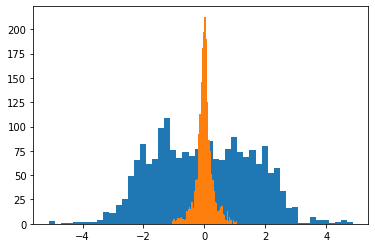

In [6]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

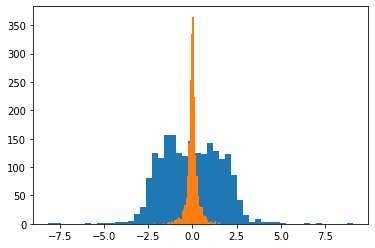

In [7]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

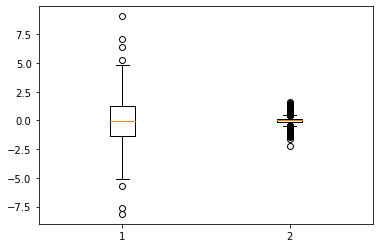

In [8]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [9]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

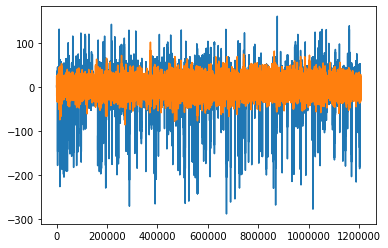

In [10]:
idx = 800
gt_data = gt[skew_idx].flatten()
fmri_data = fmri[skew_idx].flatten()
plt.plot(gt_data)
plt.plot(fmri_data)

In [11]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_signal = pm.Uniform('ampl_signal',0,5)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=ampl_signal*gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, ampl_signal, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [06:41<00:00,  9.96draws/s] 
The acceptance probability does not match the target. It is 0.8842087401786181, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876428851627465, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919699408973343, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
#pm.traceplot(posterior_2)

In [13]:
pm.summary(posterior_2)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,8.156550,0.006990,0.000193,8.142393,8.170033,1161.985323,1.002914
ampl_signal,0.138207,0.001050,0.000029,0.136060,0.140174,1250.898964,1.005605
ampl_noise,0.314995,0.001474,0.000039,0.312274,0.317989,1208.870904,1.004780


In [23]:
# now we want to see what are the contributions to the noise
sigma_mult = np.sqrt(np.sum(0.314995**2*gt_data**2)/len(gt_data))
print(sigma_mult,sigma_mult+8.156,np.std(fmri_data-gt_data))
print(np.mean(fmri_data))
print(np.mean(gt_data))

5.183736113326924 13.339736113326925 18.07844585210143
-6.823161171977761e-11
7.681250531770555e-16


In [15]:
# here is a more realistic model
#with pm.Model() as multi_noise2:
#    sigma1 = pm.Uniform('sigma1',0,5)
#    ampl1 = pm.Uniform('ampl1',0,5)
#    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
#    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
#    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
#    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

#    posterior = pm.sample(2000, tune=1000)

In [16]:
#pm.traceplot(posterior['sigma1'])

In [17]:
#pm.traceplot(posterior['ampl1'])